In [ ]:
import os , sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.layers import Input,GRU, Dense, LSTM,Embedding
from tensorflow.keras.models import Model

In [ ]:
BATCH_SIZE=64
EPOCHS=100
LATENT_DIM=256
NUM_SAMPLES=10000
MAX_SEQUENCE_LENGTH=100
MAX_NUM_WORDS=20000
EMBEDDING_DIM=100

In [ ]:
! wget http://www.manythings.org/anki/fra-eng.zip

--2024-08-27 12:57:46--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.57M  5.12MB/s    in 1.5s    

2024-08-27 12:57:48 (5.12 MB/s) - ‘fra-eng.zip’ saved [7943074/7943074]



In [ ]:
!unzip /content/fra-eng.zip

Archive:  /content/fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [ ]:
! head -5 fra.txt

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)
Go.	En route !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)
Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)


In [ ]:
input_texts= []
target_texts= []
target_texts_inputs= []


In [ ]:
t = 0
for line in open('fra.txt',encoding='utf-8'):
  t += 1
  if t > NUM_SAMPLES:
      break
  if '\t' not in line:
     continue


In [ ]:
input_text = line.rstrip().split('\t')[0]
translation = line.rstrip().split('\t')[1]


In [ ]:
target_text = translation + ' <eos>'
target_text_input = '<sos> ' + translation

input_texts.append(input_text)
target_texts.append(target_text)

target_texts_inputs.append(target_text_input)

In [ ]:
print("num samples :",len(input_texts))
print("num samples :",len(target_texts))




num samples : 1
num samples : 1


In [ ]:
tokenizer_outputs=Tokenizer(num_words=MAX_NUM_WORDS,filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences=tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs=tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [ ]:
word2idx_outputs=tokenizer_outputs.word_index
print('Found %s unique output tokens'%(len(word2idx_outputs)))


Found 6 unique output tokens


In [ ]:
num_words_output=len(word2idx_outputs)+1
max_len_target=max(len(s) for s in target_sequences)
max_len_target

5

In [ ]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)


In [ ]:
max_len_input = max(len(s) for s in input_sequences)
encoder_inputs=pad_sequences(input_sequences,maxlen=max_len_input)
print("encoder_inputs.shape:",encoder_inputs.shape)
print("encoder_inputs[0]:",encoder_inputs[0])


encoder_inputs.shape: (1, 3)
encoder_inputs[0]: [1 2 3]


In [ ]:
decoder_inputs=pad_sequences(target_sequences_inputs,maxlen=max_len_target,padding='post')
print("decoder_inputs[0]:",decoder_inputs[0])
print("decoder_inputs.shape:",decoder_inputs.shape)
decoder_targets=pad_sequences(target_sequences,maxlen=max_len_target,padding='post')

decoder_inputs[0]: [6 1 2 3 4]
decoder_inputs.shape: (1, 5)


In [ ]:
print('Loading word vectors...')
word2vec={}
with open(os.path.join('/content/fra.txt')) as f:
  for line in f:
    values=line.split()
    word=values[0]
    try:
        vec=np.asarray(values[1:],dtype='float32')
    except ValueError:
        print(f"Skipping line due to non-numerical value: {line}")
        continue  # Skip to the next line
    word2vec[word]=vec
print('Found %s word vectors.'%len(word2vec))

Streaming output truncated to the last 5000 lines.

Skipping line due to non-numerical value: "You're the kindest person I've ever met." "You say that to everyone."	« Tu es la personne la plus gentille que j'ai jamais rencontrée. » « Tu dis ça à tout le monde. »	CC-BY 2.0 (France) Attribution: tatoeba.org #1140204 (CK) & #11335491 (Micsmithel)

Skipping line due to non-numerical value: According to the weather forecast, the typhoon is approaching Okinawa.	Selon la météo, le typhon s'approche d'Okinawa.	CC-BY 2.0 (France) Attribution: tatoeba.org #278902 (CK) & #129478 (Sbgodin)

Skipping line due to non-numerical value: Additional imports of American beef are planned to meet rising demand.	Il est prévu d'augmenter l'importation de bœuf américain pour satisfaire la demande croissante.	CC-BY 2.0 (France) Attribution: tatoeba.org #274339 (CM) & #129058 (dominiko)

Skipping line due to non-numerical value: After a bit of googling, I suspect that what you said may not be true.	Après quelque

In [ ]:
word2idx_inputs = tokenizer_inputs.word_index
print('Filling pre-trained embeddings...')
num_words=min(MAX_NUM_WORDS,len(word2idx_inputs)+1)
Embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx_inputs.items():
  if i<MAX_NUM_WORDS:
    Embedding_vector=word2vec.get(word)
    if Embedding_vector is not None:
      Embedding_matrix[i]=Embedding_vector

Filling pre-trained embeddings...


In [ ]:

embedding_layer=Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[Embedding_matrix],
    input_length=max_len_input
)

In [ ]:
decoder_targets_one_hot=np.zeros((
    len(input_texts),
    max_len_target,
    num_words_output
),dtype='float32')

In [ ]:
for i,d in enumerate(decoder_targets):
  for t,word in enumerate(d):
    if word>0:
      decoder_targets_one_hot[i,t,word]=1

In [ ]:
encoder_inputs_placeholder=Input(shape=(max_len_input,))
x=embedding_layer(encoder_inputs_placeholder)
encoder=LSTM(LATENT_DIM,return_state=True)
encoder_outputs,h,c=encoder(x)
encoder_states=[h,c]

In [ ]:
decoder_inputs_placeholder=Input(shape=(max_len_target,))
decoder_embedding=Embedding(num_words_output,LATENT_DIM)
decoder_inputs_x=decoder_embedding(decoder_inputs_placeholder)

In [ ]:
decoder_lstm=LSTM(LATENT_DIM,return_sequences=True,return_state=True)
decoder_outputs,_,_=decoder_lstm(decoder_inputs_x,initial_state=encoder_states)

In [ ]:
decoder_dense=Dense(num_words_output,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)

In [ ]:
model=Model([encoder_inputs_placeholder,decoder_inputs_placeholder],decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 3)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 3, 100)         │            400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 5, 256)         │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        365,568 │ embedding_1[0][0]      │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 5, 256),       │        525,312 │ embedding_2[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 5, 7)           │          1,799 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 894,871 (3.41 MB)

 Trainable params: 894,871 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
r=model.fit(
    [encoder_inputs,decoder_inputs],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=5,

)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2000 - loss: 1.9423
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 1.8999
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 1.8639
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 1.8274
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 1.7877


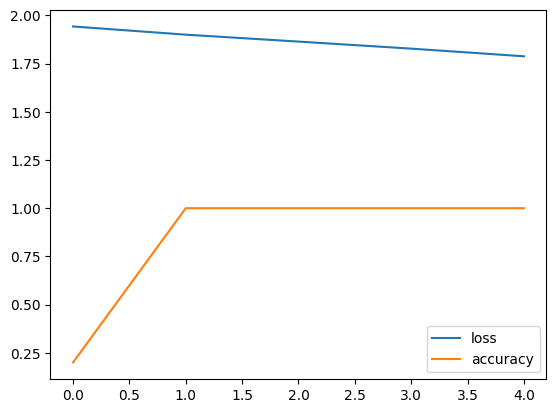

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['accuracy'],label='accuracy')
plt.legend()
plt.show()

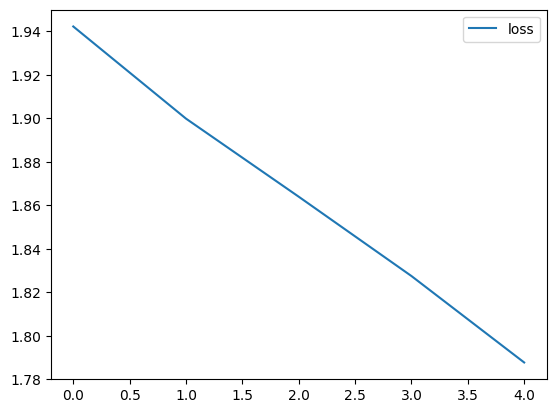

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.legend()
plt.show()

In [ ]:
encoder_model=Model(encoder_inputs_placeholder,encoder_states)

In [ ]:
decoder_state_input_h=Input(shape=(LATENT_DIM,))
decoder_state_input_c=Input(shape=(LATENT_DIM,))
decoder_states_inputs=[decoder_state_input_h,decoder_state_input_c]
decoder_inputs_single=Input(shape=(1,))
decoder_inputs_single_x=decoder_embedding(decoder_inputs_single)
decoder_outputs,h,c=decoder_lstm(decoder_inputs_single_x,initial_state=decoder_states_inputs)

decoder_states=[h,c]
decoder_outputs=decoder_dense(decoder_outputs)
decoder_model=Model(
    [decoder_inputs_single]+decoder_states_inputs,
    [decoder_outputs]+decoder_states
)

In [ ]:
idx2word_eng={v:k for k,v in word2idx_inputs.items()}
idx2word_trans={v:k for k,v in word2idx_outputs.items()}

In [ ]:
def decode_sequence(input_seq):
  states_value=encoder_model.predict(input_seq)
  # Initialize target_seq as a NumPy array
  target_seq=np.zeros((1,1))
  target_seq[0,0]=word2idx_outputs['<sos>']
  eos=word2idx_outputs['<eos>']
  output_sentence=[]
  for _ in range(max_len_target):
    output_tokens,h,c=decoder_model.predict([target_seq]+states_value)

    # Update target_seq for the next iteration
    idx = np.argmax(output_tokens[0, 0, :])
    target_seq[0, 0] = idx  # Assign the predicted index to target_seq

    if eos==idx:
      break
    word=''
    if idx>0:
      word=idx2word_trans[idx]
      output_sentence.append(word)

  # No need for the lines causing the error
  # idx=0
  # target_sequences[0][0] = idx
  # states_value = [h, c]

  return ''.join(output_sentence) # Return the generated sentence

In [ ]:
while True:
  i=np.random.choice(len(input_texts))
  input_seq=encoder_inputs[i:i+1]
  translation=decode_sequence(input_seq)
  print('-')
  print('Input:',input_texts[i])
  print('Translation:',translation)


  ans=input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-
Input: We're so busy.
Translation: onesttellementoccupés !
Continue? [Y/n]hindi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
-
Input: We're so busy.
Translation: onesttellementoccupés !
Continue? [Y/n]Y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
-
Input: We're so busy.
Translation: onesttellementoccupés !


KeyboardInterrupt: Interrupted by user